In [1]:
## System
import sys
import os
from collections import defaultdict

## Pandas
import pandas as pd
import numpy as np

## Plotting 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Fig utils 
from fig_utils import (get_decile_score, 
                       deciles, 
                       HI_color,
                       NonEss_color)


In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
## genic ConSplice file path
autosome_genic_consplice_file = "../data/ConSplice.gene.scores.autosome.txt"
chrx_genic_consplice_file = "../data/ConSplice.gene.scores.chrX.txt"

In [3]:
## score columns
consplice_col = "weighted_sc_percentile"

In [4]:
## Read in the genic ConSplice scores into pandas data frame
autosome_ConSplice_df = pd.read_csv(autosome_genic_consplice_file, sep = "\t", index_col = False)
chrx_ConSplice_df = pd.read_csv(chrx_genic_consplice_file, sep = "\t", index_col = False)
ConSplice_df = pd.concat([autosome_ConSplice_df,chrx_ConSplice_df])

In [5]:
## Load CRISPR gene sets

crispr_essentail_genes = "../data/CRISPR.Essential.genes.tsv"
with open(crispr_essentail_genes) as ceg:
    crispr_essentail = [x.strip() for x in ceg]

crispr_non_essentail_genes = "../data/CRISPR.Nonessential.genes.tsv"
with open(crispr_non_essentail_genes) as cneg:
    crispr_non_essentail = [x.strip() for x in cneg]

In [6]:
## Create new df with gene info 

crispr_df_list = []

crispr_df_list.extend([[gene,"CRISPR Essential"] for gene in crispr_essentail])
crispr_df_list.extend([[gene,"CRISPR Non-Essential"] for gene in crispr_non_essentail])

crispr_gene_list_df = pd.DataFrame(crispr_df_list, columns = ["gene","gene_list"])

del crispr_df_list

In [7]:
## Add ConSplice scores to gene df

o_e_gene_set = set(ConSplice_df.gene_symbol)
crispr_gene_list_df["ConSplice"] = crispr_gene_list_df.gene.apply(lambda x: ConSplice_df.loc[ConSplice_df.gene_symbol == x][consplice_col].values[0] if x in o_e_gene_set else "Missing" )

In [8]:
crispr_gene_list_df.groupby("gene_list").describe()

gene                        ConSplice                  \
                     count unique        top freq     count unique      top   
gene_list                                                                     
CRISPR Essential       683    683       RPA1    1       683    611  Missing   
CRISPR Non-Essential   913    913  C10orf113    1       913    710  Missing   

                           
                     freq  
gene_list                  
CRISPR Essential       73  
CRISPR Non-Essential  204

In [9]:
## Bin scores and normalize counts

crispr_gene_list_df["constraint_decile"] = crispr_gene_list_df.ConSplice.apply(get_decile_score)

normalized_crispr_gene_list_df = crispr_gene_list_df.loc[crispr_gene_list_df.constraint_decile != "None"].groupby("gene_list")["constraint_decile"].value_counts(normalize=True).reset_index(name='percentage')

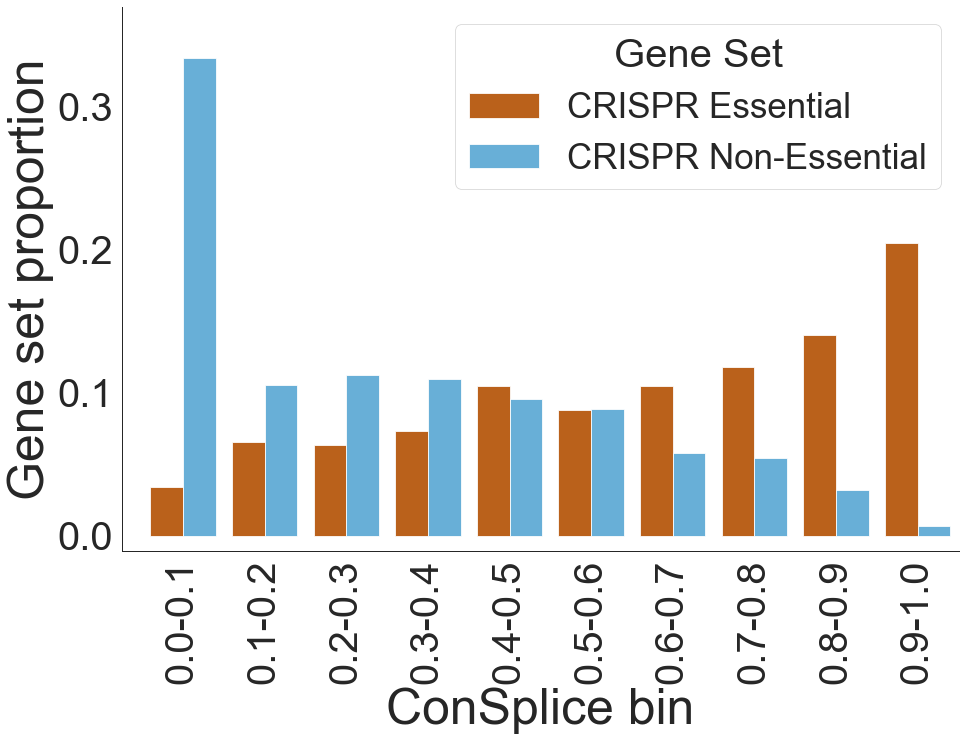

In [11]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

fig, ax = plt.subplots(figsize = (15,10))
sns.set(font='Arial', style = "white")
sns.set_context("paper", font_scale = 2)
sns.despine()

sns.barplot(data = normalized_crispr_gene_list_df, 
            x = "constraint_decile", 
            y = "percentage", 
            hue = "gene_list",
            order = deciles,
            palette = [HI_color,NonEss_color])

plt.ylabel('Gene set proportion', fontsize = 50)
plt.xlabel("ConSplice bin", fontsize = 50)

   
ax.tick_params(axis="x", labelsize=40, rotation = 90 )
ax.tick_params(axis="y", labelsize=40)  
plt.legend(title = "Gene Set", fontsize = 35, title_fontsize = 40)
ax.set_ylim(-0.01,0.37)
ax.set_xlim(-0.75,9.5)

plt.savefig('../figures/suppl_figure3_B.svg')